# Bayesian inversion of Young's modulus field in the linear elasticity problem

In [1]:
import sys
import os
import time
import numpy as np
import dolfin as dl

import pickle

import torch

from scipy.interpolate import griddata

src_path = "../../../src/"
sys.path.append(src_path + 'plotting')
from field_plot import *
from plot_mix_collection import *
from point_plot import *
from plot_curve import plot_curve

model_path = "../../problems/linear_elasticity/"
sys.path.append(model_path)
from linearElasticityModel import LinearElasticityModel

sys.path.append(src_path + 'prior')
from priorSampler import PriorSampler

sys.path.append(src_path + 'mcmc')
from mcmc import MCMC
from mcmc_plot_fields import mcmc_plot_fields, mcmc_plot_fields_base
from compute_sample_errors import compute_sample_errors
from surrogateModel import SurrogateModel, SurrogateModelFNO

sys.path.append(src_path + 'nn/deeponet')
sys.path.append(src_path + 'data/')
sys.path.append(src_path + 'nn/mlp')
from load_data_and_deeponet import load_data_and_deeponet

sys.path.append(src_path + 'nn/pcanet')
from load_data_and_pcanet import load_data_and_pcanet

sys.path.append(src_path + 'nn/fno')
from load_data_and_fno import load_data_and_fno

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)

In [2]:
model_data_folder = model_path + 'data/'
current_directory = os.getcwd()
results_dir = current_directory + '/Results/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Create LinearElasticityModel

In [3]:
prior_ac = 0.005
prior_cc = 0.2
prior_logn_scale = 100.
prior_logn_translate = 1000.
nx, ny = 50, 50
fe_order = 1
data_prefix = 'LinearElasticity'

# create mesh
mesh = dl.UnitSquareMesh(nx, ny)

# create function spaces
Vm = dl.FunctionSpace(mesh, 'Lagrange', fe_order)
Vu = dl.VectorFunctionSpace(mesh, "Lagrange", fe_order)

# create prior sampler
prior_sampler = PriorSampler(Vm, prior_ac, prior_cc, seed)

# create model
model = LinearElasticityModel(Vm, Vu, prior_sampler, prior_logn_scale, prior_logn_translate, seed)

# Load Neural Operators

In [4]:
surrogate_models = None
load_surrogate = True

In [5]:
if load_surrogate:
    def load_deeponet():
        data_path = model_path + 'data/' + 'LinearElasticity_samples.npz'
        nn_path = model_path + 'DeepONet/Results/model.pkl'
        data, nn = load_data_and_deeponet(data_path, nn_path)
        nn_surrogate = SurrogateModel(model, nn, data)
        print('nn_data: ', data)
        print('nn_model: ', nn)

        return nn_surrogate

    deeponet = load_deeponet()

nn_data:  <dataMethods.DataProcessor object at 0x76e3775c4310>
nn_model:  DeepONet(
  (branch_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2601, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=200, bias=True)
    )
  )
  (trunk_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
    )
  )
)


In [6]:
if load_surrogate:
    def load_pcanet():
        data_path = model_path + 'data/' + 'LinearElasticity_samples.npz'
        nn_path = model_path + 'PCANet/Results/model.pkl'
        data, nn = load_data_and_pcanet(data_path, nn_path)
        nn_surrogate = SurrogateModel(model, nn, data)
        print('nn_data: ', data)
        print('nn_model: ', nn)

        return nn_surrogate

    pcanet = load_pcanet()  

nn_data:  <dataMethods.DataProcessor object at 0x76e37753ee50>
nn_model:  PCANet(
  (net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=50, out_features=250, bias=True)
      (1-2): 2 x Linear(in_features=250, out_features=250, bias=True)
      (3): Linear(in_features=250, out_features=50, bias=True)
    )
  )
)


In [7]:
if load_surrogate:
    def load_fno():
        data_path = model_path + 'data/' + 'LinearElasticity_FNO_samples.npz'
        nn_path = model_path + 'FNO/Results/model.pkl'
        data, nn = load_data_and_fno(data_path, nn_path)
        # get some additional data for FNO
        nodes = deeponet.data.X_trunk
        grid_x = data.grid_x_test[0, :, :, 0]
        grid_y = data.grid_y_test[0, :, :, 0]
        nn_surrogate = SurrogateModelFNO(model, nn, data, nodes, grid_x, grid_y, u_comps = 2)
        print('nn_data: ', data)
        print('nn_model: ', nn)

        return nn_surrogate

    fno = load_fno()

nn_data:  <dataMethods.DataProcessorFNO object at 0x76e3665470d0>
nn_model:  FNO2D(
  (fno_layers): ModuleList(
    (0-2): 3 x FNO2DLayer(
      (w): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (input_projector): Linear(in_features=3, out_features=20, bias=True)
  (output_projector): Linear(in_features=20, out_features=2, bias=True)
)


In [8]:
if load_surrogate:
    surrogate_models = {'DeepONet': deeponet, 'PCANet': pcanet, 'FNO': fno}

In [9]:
if load_surrogate:
    t1 = time.time()
    w1 = model.samplePrior(transform_m = False)
    w2 = w1.copy()
    t2 = time.time()
    print('Time to sample m: {:.3f}'.format(t2 - t1))

    # model solver
    t1 = time.time()
    m = model.transform_gaussian_pointwise(w1)
    u_model = model.solveFwd(u = None, m = m, transform_m = False)
    t2 = time.time()
    print('Time to solve LinearElasticity model forward: {:.3f}'.format(t2 - t1))

    # neural operators
    sm_use = ['DeepONet', 'PCANet', 'FNO']
    for sm in sm_use:
        t1 = time.time()
        u_sm = surrogate_models[sm].solveFwd(w2)
        t2 = time.time()
        u_err = np.linalg.norm(u_model - u_sm) / np.linalg.norm(u_model)
        print('Time to solve {} forward: {:.3f}, err: {:.3e}'.format(surrogate_models[sm].model_type, t2 - t1, u_err))

Time to sample m: 0.052
Time to solve LinearElasticity model forward: 0.323
Time to solve DeepONet forward: 0.122, err: 4.787e-04
Time to solve PCANet forward: 0.003, err: 3.906e-04
Time to solve FNO forward: 0.125, err: 2.506e-04


# Get ground truth

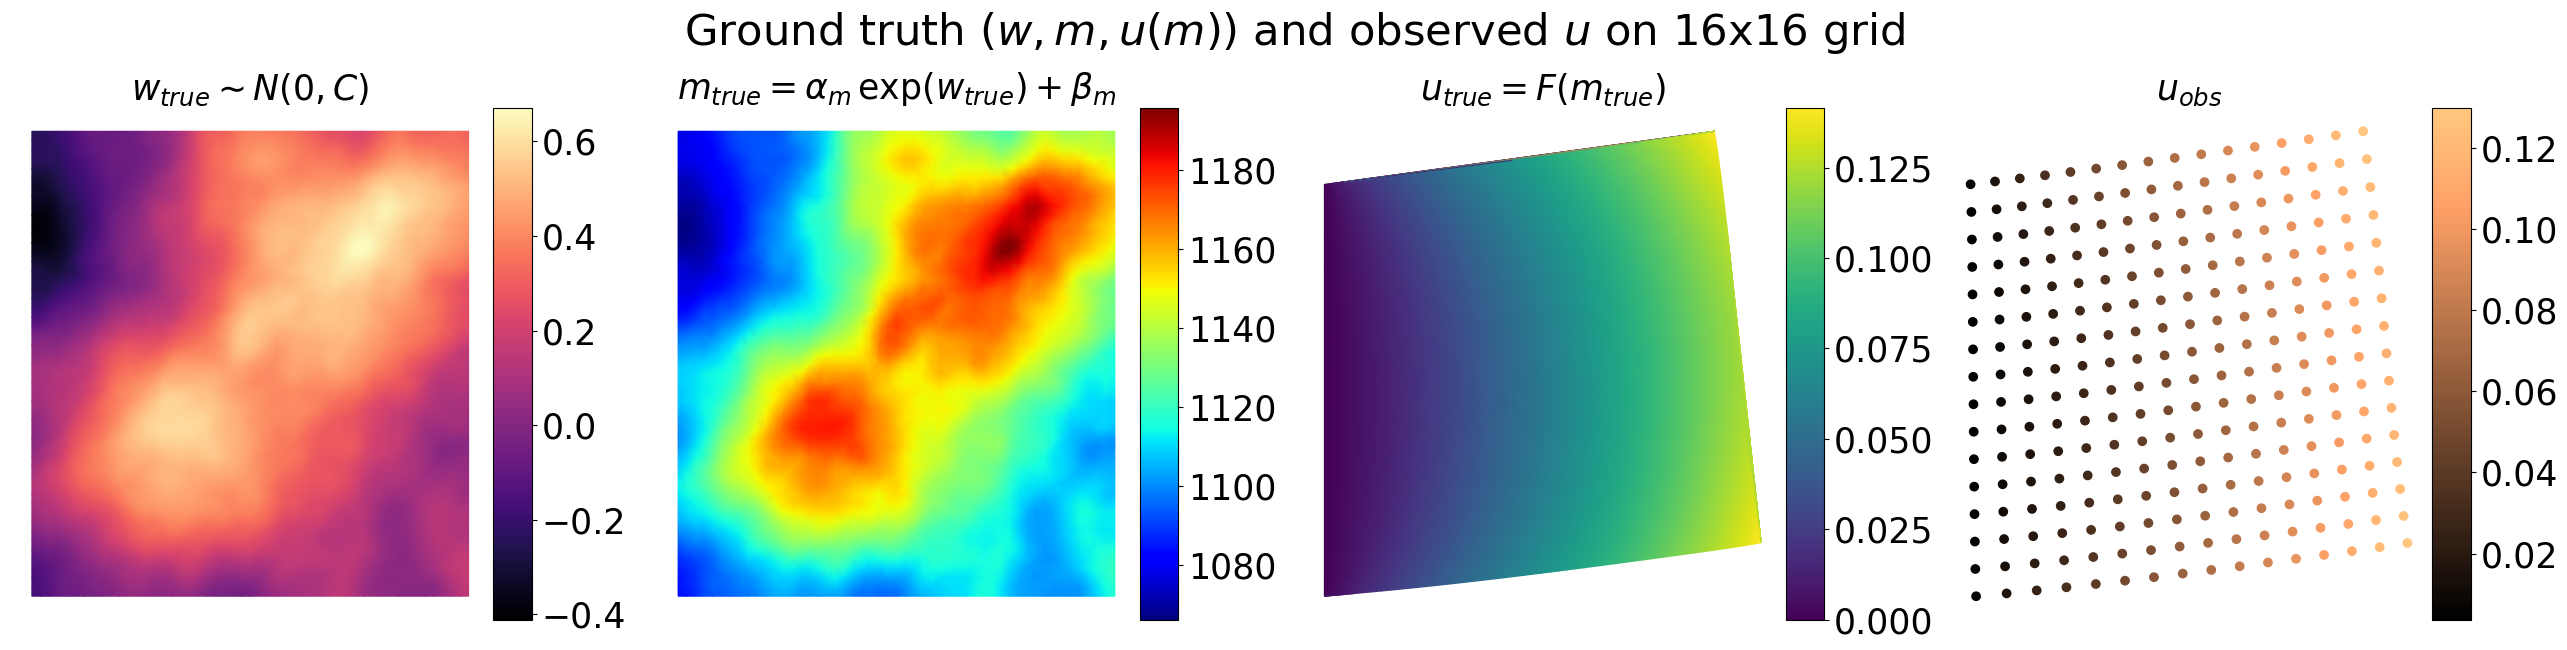

In [10]:
# load
ground_truth_data = np.load(results_dir + 'ground_truth/data.npz')
num_grid_x, num_grid_y = ground_truth_data['num_grid_x'], ground_truth_data['num_grid_y']
w_true = ground_truth_data['w_true']
m_true = ground_truth_data['m_true']
u_true = ground_truth_data['u_true']
x_obs = ground_truth_data['x_obs']
u_obs = ground_truth_data['u_obs']


# plot
uvec = [[w_true, m_true, u_true, u_obs]]
title_vec = [[r'$w_{true} \sim N(0, C)$', r'$m_{true} = \alpha_m\, \exp(w_{true}) + \beta_m$', r'$u_{true} = F(m_{true})$', r'$u_{obs}$']]
cmap_vec = [['magma', 'jet', 'viridis', 'copper']]
flag_is_vec = [[False, False, True, True]]
flag_add_disp = [[False, False, True, True]]
plot_type = [['field', 'field', 'field', 'point']]
sup_title = r'Ground truth $(w, m, u(m))$ and observed $u$ on {}x{} grid'.format(num_grid_x, num_grid_y)
savefilename = results_dir + 'true_and_obs_w_m_u.png'

plot_data = get_default_plot_mix_collection_data(rows = 1, \
    cols = 4, \
    nodes = model.u_nodes, \
    nodes_point_plot = x_obs, \
    figsize = (26, 6), fs = 25, \
    sup_title =  sup_title, \
    y_sup_title = 1.075, \
    savefilename = savefilename, \
    u = uvec, cmap = cmap_vec, title = title_vec, \
    is_vec = flag_is_vec, add_disp = flag_add_disp, \
    plot_type = plot_type)

plot_mix_collection(plot_data)

## Compute noise

In [27]:
u_obs_mean, u_obs_std = np.mean(u_obs), np.std(u_obs)
sigma_noise = 0.01 * u_obs_mean
print('u_obs_mean = {:.3e}, u_obs_std = {:.3e}, sigma_noise: {:.3e}'.format(u_obs_mean, u_obs_std, sigma_noise))

u_obs_mean = 2.865e-02, u_obs_std = 4.111e-02, sigma_noise: 2.865e-04


# Bayesian parameter estimation setup

In [36]:
surrogate_to_use = None

mcmc = MCMC(model, prior_sampler, ground_truth_data, \
            sigma_noise = sigma_noise, pcn_beta = 0.2, \
            surrogate_to_use = surrogate_to_use, \
            surrogate_models = surrogate_models, \
            seed = seed)

print('u_comps: {}'.format(mcmc.u_comps))

# display low-res files for testing
mcmc.pp_params = {'curve_plot': {'fs': 12, 'lw': 3, 'figsize': (4,3)}, \
                          'field_plot': {'fs': 10, 'y_sup_title': 1.025, 'figsize': (8, 6), 'ttl_pad': 5, 'u_vec_plot': True}}

u_comps: 2


--------------------------------------------------
MCMC started with 10000 samples and 500 burnin
PCN beta: 1.500e-01, sigma_noise: 2.865e-04
Model used for solving the forward problem: True Model
Tracer save path: test_mcmc_results_n_samples_10000_n_burnin_500_pcn_beta_0.150_sigma_2.865e-04
Tracer save filename: tracer
--------------------------------------------------
initializing the current state. Initial cost: 1.807e+03
--------------------------------------------------
Burnin:    0, Cost: 1.807e+03
--------------------------------------------------
--------------------------------------------------
Sample:  500, Accepted samples:    0, Acceptance Rate: 0.000e+00, Cost mean: 0.000e+00. 
Tracing 500 samples took 9.998e+01s
Error (%) in w: ||w - w_mean|| = 1.000e+02, ||w - w_sample|| = 1.000e+02
Error (%) in m: ||m - m_mean|| = 3.721e+00, ||m - m_sample|| = 3.721e+00
Error (%) in u: ||u - u_mean|| = 1.660e+00, ||u - u_sample|| = 1.660e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| =

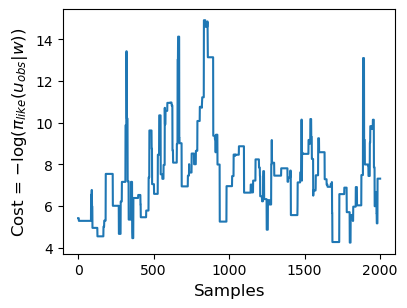

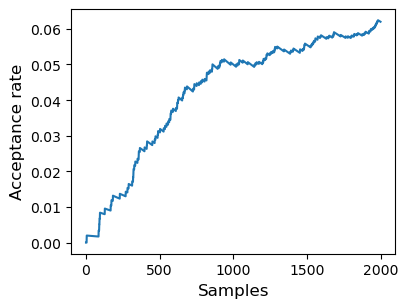

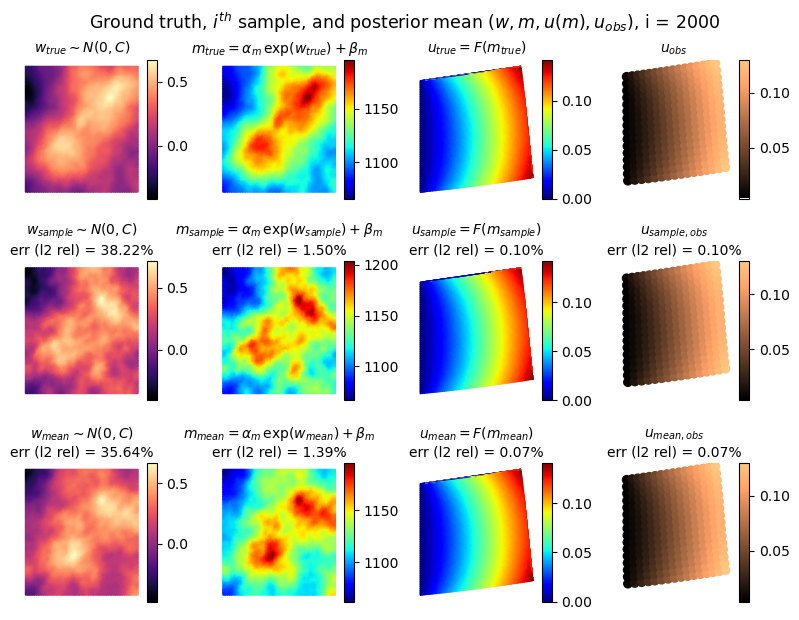

--------------------------------------------------
Sample: 3000, Accepted samples:  185, Acceptance Rate: 6.167e-02, Cost mean: 7.099e+00. 
Tracing 500 samples took 1.407e+02s
Error (%) in w: ||w - w_mean|| = 3.466e+01, ||w - w_sample|| = 3.966e+01
Error (%) in m: ||m - m_mean|| = 1.356e+00, ||m - m_sample|| = 1.598e+00
Error (%) in u: ||u - u_mean|| = 6.679e-02, ||u - u_sample|| = 8.204e-02
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 6.466e-02, ||u_obs - u_obs_sample|| = 8.221e-02
--------------------------------------------------
--------------------------------------------------
Sample: 3500, Accepted samples:  216, Acceptance Rate: 6.171e-02, Cost mean: 7.250e+00. 
Tracing 500 samples took 1.435e+02s
Error (%) in w: ||w - w_mean|| = 3.449e+01, ||w - w_sample|| = 5.071e+01
Error (%) in m: ||m - m_mean|| = 1.349e+00, ||m - m_sample|| = 2.002e+00
Error (%) in u: ||u - u_mean|| = 6.786e-02, ||u - u_sample|| = 1.221e-01
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 6.485e-02, ||u_obs - 

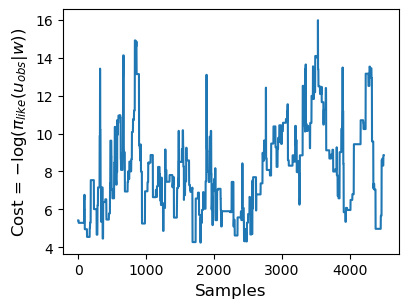

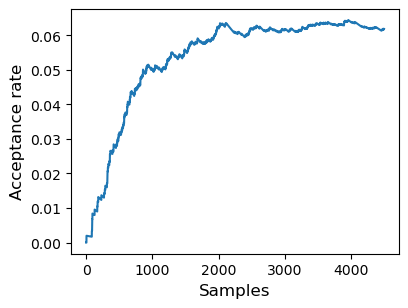

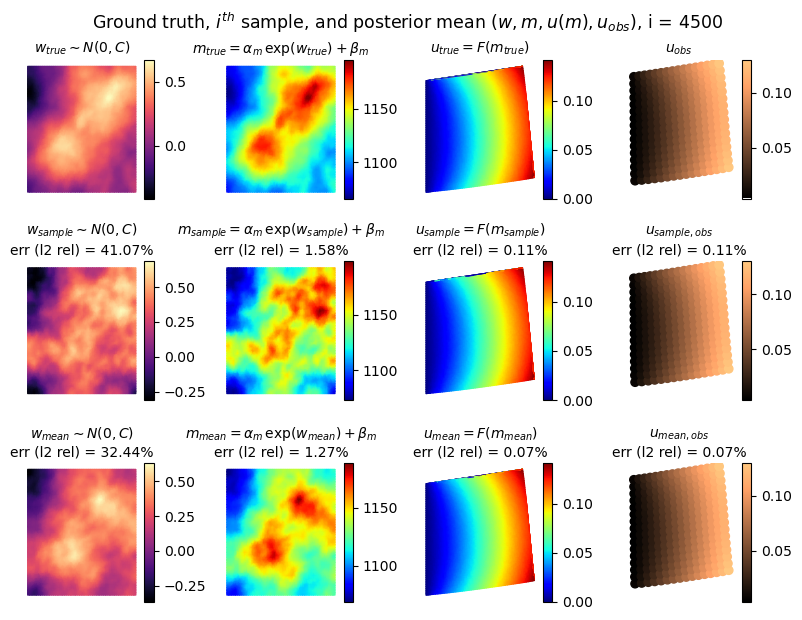

--------------------------------------------------
Sample: 5500, Accepted samples:  342, Acceptance Rate: 6.218e-02, Cost mean: 7.929e+00. 
Tracing 500 samples took 1.633e+02s
Error (%) in w: ||w - w_mean|| = 3.167e+01, ||w - w_sample|| = 4.436e+01
Error (%) in m: ||m - m_mean|| = 1.241e+00, ||m - m_sample|| = 1.633e+00
Error (%) in u: ||u - u_mean|| = 7.204e-02, ||u - u_sample|| = 7.812e-02
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 7.054e-02, ||u_obs - u_obs_sample|| = 7.921e-02
--------------------------------------------------
--------------------------------------------------
Sample: 6000, Accepted samples:  386, Acceptance Rate: 6.433e-02, Cost mean: 7.827e+00. 
Tracing 500 samples took 1.674e+02s
Error (%) in w: ||w - w_mean|| = 3.048e+01, ||w - w_sample|| = 4.488e+01
Error (%) in m: ||m - m_mean|| = 1.199e+00, ||m - m_sample|| = 1.627e+00
Error (%) in u: ||u - u_mean|| = 7.081e-02, ||u - u_sample|| = 6.663e-02
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 6.982e-02, ||u_obs - 

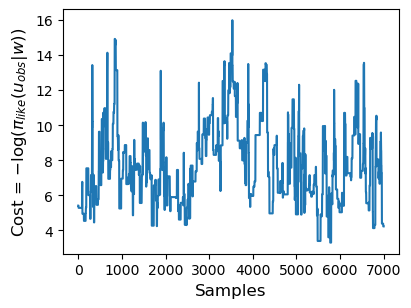

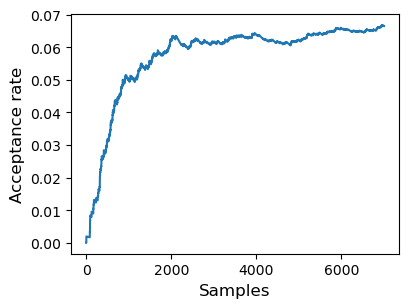

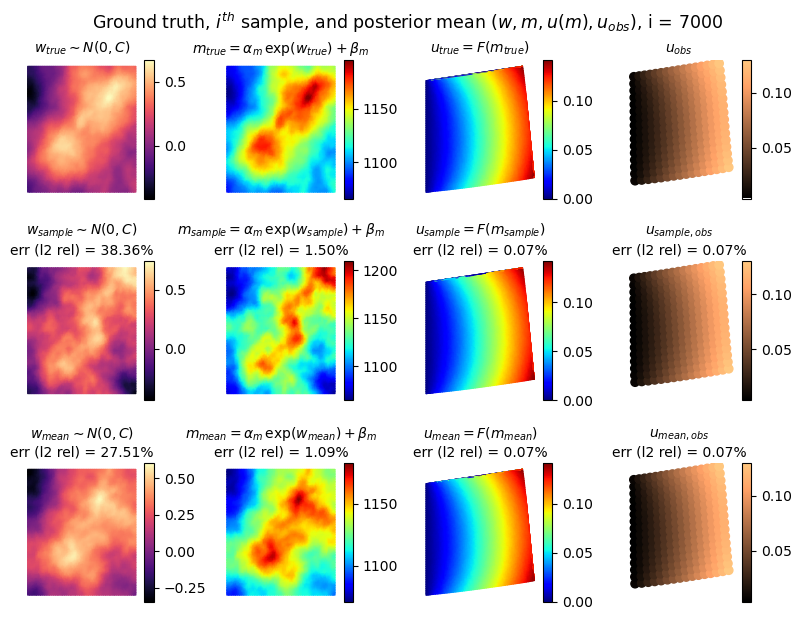

--------------------------------------------------
Sample: 8000, Accepted samples:  522, Acceptance Rate: 6.525e-02, Cost mean: 7.421e+00. 
Tracing 500 samples took 1.903e+02s
Error (%) in w: ||w - w_mean|| = 2.652e+01, ||w - w_sample|| = 3.487e+01
Error (%) in m: ||m - m_mean|| = 1.048e+00, ||m - m_sample|| = 1.416e+00
Error (%) in u: ||u - u_mean|| = 6.765e-02, ||u - u_sample|| = 7.222e-02
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 6.751e-02, ||u_obs - u_obs_sample|| = 6.852e-02
--------------------------------------------------
--------------------------------------------------
Sample: 8500, Accepted samples:  557, Acceptance Rate: 6.553e-02, Cost mean: 7.333e+00. 
Tracing 500 samples took 1.933e+02s
Error (%) in w: ||w - w_mean|| = 2.600e+01, ||w - w_sample|| = 4.015e+01
Error (%) in m: ||m - m_mean|| = 1.027e+00, ||m - m_sample|| = 1.443e+00
Error (%) in u: ||u - u_mean|| = 6.623e-02, ||u - u_sample|| = 8.684e-02
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 6.598e-02, ||u_obs - 

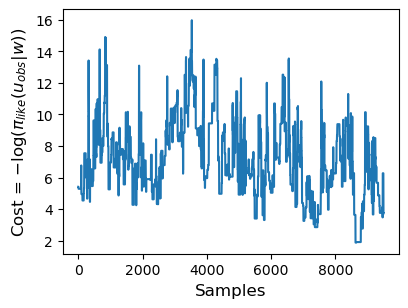

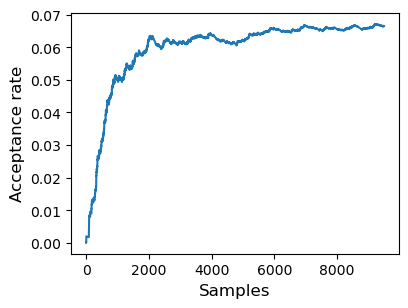

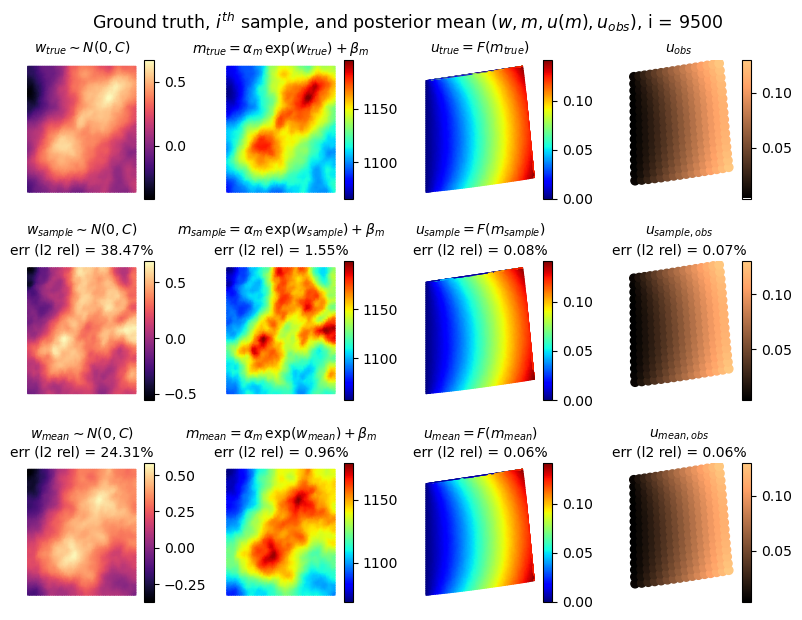

--------------------------------------------------
MCMC finished in 3.404e+03s. 
Total samples: 10500, Accepted samples:  699, Acceptance Rate: 6.657e-02, Cost mean: 7.064e+00
--------------------------------------------------


In [37]:
n_samples = 10000
n_burnin = 500
pcn_beta = 0.15
print_every = 500
display_plot_every = 5*print_every

mcmc.surrogate_to_use = None

savepath_base = results_dir + 'test_mcmc_results_n_samples_{:d}_n_burnin_{:d}_pcn_beta_{:.3f}_sigma_{:.3e}'.format(n_samples, n_burnin, pcn_beta, sigma_noise)

if mcmc.surrogate_to_use is not None:
    savepath = savepath_base + '_surrogate_{}/'.format(mcmc.surrogate_to_use)
else:
    savepath = savepath_base + '/'

os.makedirs(savepath, exist_ok = True)

savefilename = 'tracer'

mcmc.run(n_samples = n_samples, n_burnin = n_burnin, \
         pcn_beta = pcn_beta, sigma_noise = sigma_noise, \
         print_every = print_every, print_lvl = 2, \
         display_plot_every = display_plot_every, \
         savefilename = savefilename, \
         init_tracer = True, \
         savepath = savepath)

# Use surrogate and run the same problem

### DeepONet

In [ ]:
mcmc.surrogate_to_use = 'DeepONet'

if mcmc.surrogate_to_use is not None:
    savepath = savepath_base + '_surrogate_{}/'.format(mcmc.surrogate_to_use)
else:
    savepath = savepath_base + '/'

os.makedirs(savepath, exist_ok = True)

savefilename = 'tracer'

run_mcmc = False
if run_mcmc:
    mcmc.run(n_samples = n_samples, n_burnin = n_burnin, \
         pcn_beta = pcn_beta, sigma_noise = sigma_noise, \
         print_every = print_every, print_lvl = 2, \
         display_plot_every = display_plot_every, \
         savefilename = savefilename, \
         savepath = savepath, init_tracer = True)

### PCANet

In [ ]:
mcmc.surrogate_to_use = 'PCANet'

if mcmc.surrogate_to_use is not None:
    savepath = savepath_base + '_surrogate_{}/'.format(mcmc.surrogate_to_use)
else:
    savepath = savepath_base + '/'

os.makedirs(savepath, exist_ok = True)

savefilename = 'tracer'

run_mcmc = False
if run_mcmc:
    mcmc.run(n_samples = n_samples, n_burnin = n_burnin, \
         pcn_beta = pcn_beta, sigma_noise = sigma_noise, \
         print_every = print_every, print_lvl = 2, \
         display_plot_every = display_plot_every, \
         savefilename = savefilename, \
         savepath = savepath, init_tracer = True)

### FNO

In [ ]:
mcmc.surrogate_to_use = 'FNO'

if mcmc.surrogate_to_use is not None:
    savepath = savepath_base + '_surrogate_{}/'.format(mcmc.surrogate_to_use)
else:
    savepath = savepath_base + '/'

os.makedirs(savepath, exist_ok = True)

savefilename = 'tracer'

run_mcmc = True
if run_mcmc:
    mcmc.run(n_samples = n_samples, n_burnin = n_burnin, \
         pcn_beta = pcn_beta, sigma_noise = sigma_noise, \
         print_every = print_every, print_lvl = 2, \
         display_plot_every = display_plot_every, \
         savefilename = savefilename, \
         savepath = savepath, init_tracer = True)